In [25]:
import numpy as np 
import xarray as xr 
import os 
import matplotlib.pyplot as plt 
import netCDF4 as nc
from scipy import interpolate
import pickle
import sys

In [36]:
# os.environ['WK_DIR'] = '/localdrive/drive10/jj/mdtf/wkdir/MDTF_QBOi.EXP1.AMIP.v4.001_2008_2012/etc_composites'
os.environ['WK_DIR'] = '/localdrive/drive10/jj/mdtf/wkdir/MDTF_QBOi.EXP1.AMIP.v2.001_2008_2008/etc_composites'

os.environ['POD_HOME'] = '/localdrive/drive10/jj/mdtf/MDTF-diagnostics/diagnostics/etc_composites'
os.environ['DATADIR'] = '/localdrive/drive10/jj/mdtf/inputdata/model/QBOi.EXP1.AMIP.001'
os.environ['OBS_DATA'] = '/localdrive/drive10/jj/mdtf/inputdata/obs_data/etc_composites'
os.environ['CASENAME'] = 'QBOi.EXP1.AMIP.001'

os.environ['FIRSTYR'] = '2008'
os.environ['LASTYR'] = '2012'

os.environ['topo_file'] = os.environ['DATADIR'] + '/topo.nc'
sys.path.append(os.environ['POD_HOME']+'/util')

# Setitng up the necessary variable names 
os.environ['slp_var'] = 'SLP'
os.environ['slp_file'] = '*.'+os.environ['slp_var']+'.6hr.nc'

os.environ['tp_var'] = 'PRECT'
os.environ['tp_file'] = '*.'+os.environ['tp_var']+'.6hr.nc'

os.environ['MODEL_OUTPUT_DIR']  = os.environ['DATADIR'] + '/6hr'

In [48]:
###################################################
##### Creating plots from obs/merra and era-interim
###################################################

# load in the netcdf files 
obs_file = f"{os.environ['OBS_DATA']}/modis_merra.nc"
era_file = f"{os.environ['OBS_DATA']}/era_interim.nc"

# reading in the observation file
ds = xr.open_dataset(obs_file)
obs_x = ds['X'].values
obs_y = ds['Y'].values
modis_cld = ds['modis_cld'].values
merra_pw = ds['merra_pw'].values
merra_omega = ds['merra_omega'].values
ds.close()

# reading in the re-analysis file
ds = xr.open_dataset(era_file)
erai_x = ds['X'].values
erai_y = ds['Y'].values
pr_nh_ocean_warm = ds['pr_nh_ocean_warm'].values
prw_nh_ocean_warm = ds['prw_nh_ocean_warm'].values
ws_nh_ocean_warm = ds['ws_nh_ocean_warm'].values
pr_sh_ocean_warm = ds['pr_sh_ocean_warm'].values
prw_sh_ocean_warm = ds['prw_sh_ocean_warm'].values
ws_sh_ocean_warm = ds['ws_sh_ocean_warm'].values
ds.close()


############################################################
####### Creating Difference Plots
############################################################

# regrdding the observation data 
## setting up the necessary x,y values in the format required for griddata
obs_x_1d = obs_x.flatten()
obs_y_1d = obs_y.flatten()

modis_cld_1d = modis_cld.flatten()
merra_pw_1d = merra_pw.flatten()
merra_omega_1d = merra_omega.flatten()

## the erai x and y are 1d, have to convert it to a 2d grid
erai_x_grid, erai_y_grid = np.meshgrid(erai_x, erai_y)
erai_x_1d = erai_x_grid.flatten()
erai_y_1d = erai_y_grid.flatten()

# interpolating the ang, dist plots from observations on to the erai standard grid (same grid as the outputs from the model)
erai_modis_cld = interpolate.griddata((obs_x_1d, obs_y_1d), modis_cld_1d, (erai_x_1d, erai_y_1d))
erai_modis_cld = erai_modis_cld.reshape(erai_x_grid.shape)

erai_merra_pw = interpolate.griddata((obs_x_1d, obs_y_1d), merra_pw_1d, (erai_x_1d, erai_y_1d))
erai_merra_pw = erai_merra_pw.reshape(erai_x_grid.shape)

erai_merra_omega = interpolate.griddata((obs_x_1d, obs_y_1d), merra_omega_1d, (erai_x_1d, erai_y_1d))
erai_merra_omega = erai_merra_omega.reshape(erai_x_grid.shape)


## Reading in the model composites
model_file = f"{os.environ['WK_DIR']}/tmp/RUNDIR/tmprun/read_tmprun/composites.pkl"
model_data = pickle.load(open(model_file, 'rb'))

# Creating the plots

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
# MODEL - ERA-Interim PR (Total Precip)
out_file = f"{os.environ['WK_DIR']}/model/{os.environ['CASENAME']}_erai_pr_SH_ocean_WARM.png"
hemis = 'SH'; lo = 'ocean'; season = 'warm'; var = 'tp'
model_val = model_data[hemis][lo][season][var]['area_sum']/model_data[hemis][lo][season][var]['area_cnt']
diff_val = model_val - pr_sh_ocean_warm
vmax = np.nanpercentile(np.abs(diff_val).flatten(), 80)
vmin = -1*vmax
plt.pcolormesh(erai_x, erai_y, diff_val, vmin=vmin, vmax=vmax, cmap='bwr')
plt.title(f"{os.environ['CASENAME']} - ERA-Interim\nSH OCEAN WARM PR")
plt.ylim(-1500, 1500)
plt.xlim(-1500, 1500)
plt.colorbar()

plt.subplot(2,2,2)
# MERRA - ERA-Interim
out_file = f"{os.environ['WK_DIR']}/obs/merra_erai_pw_SH_ocean_WARM.png"
diff_val = erai_merra_pw - prw_sh_ocean_warm
vmax = np.nanpercentile(np.abs(diff_val).flatten(), 80)
vmin = -1*vmax
plt.pcolormesh(erai_x, erai_y, diff_val, vmin=vmin, vmax=vmax, cmap='bwr')
plt.title(f"MERRA -  ERA-Interim\nSH OCEAN WARM PW")
plt.ylim(-1500, 1500)
plt.xlim(-1500, 1500)
plt.colorbar()

plt.subplot(2,2,3)
# MERRA - ERA-Interim
out_file = f"{os.environ['WK_DIR']}/obs/merra_erai_prw_SH_ocean_WARM.png"
hemis = 'SH'; lo = 'ocean'; season = 'warm'; var = 'prw'
model_val = model_data[hemis][lo][season][var]['area_sum']/model_data[hemis][lo][season][var]['area_cnt']
diff_val = model_val - prw_sh_ocean_warm
vmax = np.nanpercentile(np.abs(diff_val).flatten(), 80)
vmin = -1*vmax
plt.pcolormesh(erai_x, erai_y, diff_val, vmin=vmin, vmax=vmax, cmap='bwr')
plt.title(f"{os.environ['CASENAME']} - ERA-Interim\nSH OCEAN WARM PRW")
plt.ylim(-1500, 1500)
plt.xlim(-1500, 1500)
plt.colorbar()

plt.subplot(2,2,4)
# MERRA - ERA-Interim
out_file = f"{os.environ['WK_DIR']}/obs/merra_erai_prw_SH_ocean_WARM.png"
hemis = 'SH'; lo = 'ocean'; season = 'warm'; var = 'prw'
model_val = model_data[hemis][lo][season][var]['area_sum']/model_data[hemis][lo][season][var]['area_cnt']
diff_val = model_val - erai_merra_pw
vmax = np.nanpercentile(np.abs(diff_val).flatten(), 80)
vmin = -1*vmax
plt.pcolormesh(erai_x, erai_y, diff_val, vmin=vmin, vmax=vmax, cmap='bwr')
plt.title(f"{os.environ['CASENAME']} - MERRA\nSH OCEAN WARM PRW")
plt.ylim(-1500, 1500)
plt.xlim(-1500, 1500)
plt.colorbar()

plt.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: '/localdrive/drive10/jj/mdtf/wkdir/MDTF_QBOi.EXP1.AMIP.v2.001_2008_2008/etc_composites/tmp/RUNDIR/tmprun/read_tmprun/composites.pkl'

dict_keys(['tp', 'prw'])


/home/jj/anaconda3/envs/mcms/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


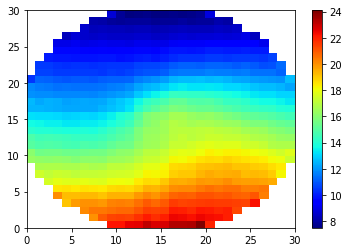

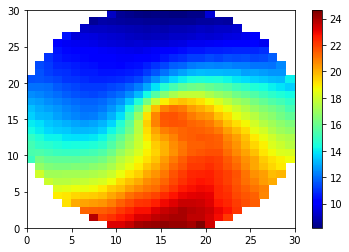

In [35]:
plt.figure()
plt.pcolormesh(prw_sh_ocean_warm, cmap='jet')
plt.colorbar()

hemis = 'SH'; lo = 'ocean'; season = 'warm'; var = 'prw'
print(model_data[hemis][lo][season].keys())
model_val = model_data[hemis][lo][season][var]['area_sum']/model_data[hemis][lo][season][var]['area_cnt']
model_val = model_val/(86400/24.)

plt.figure()
plt.pcolormesh(model_val, cmap='jet')
plt.colorbar()